# French web domain classification
## CNN and LSTM approaches
**Team: Samuel - TuAnh - HaiYen**

# Part 1 : Environment setup and data preprocessing

## Importation of the packages

In [1]:
import os, codecs
from os import path
import re

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


from nltk.corpus import stopwords 
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn import preprocessing

import csv

import networkx as nx

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Bidirectional, LSTM, Dense, Activation, Dropout

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from tensorflow.keras.layers import Bidirectional 
from tensorflow.keras.preprocessing import text

## Importation of the data

In [2]:
# Read training data
path_data = "/kaggle/input/fr-domain-classification/"

with open(path_data+"train_noduplicates.csv", 'r') as f:
    train_data = f.read().splitlines()
    
with open(path_data+"train_noduplicates.csv", 'r') as f:
    train_data = f.read().splitlines()


train_hosts = list()
y_train = list()
for row in train_data:
    host, label = row.split(",")
    train_hosts.append(host)
    y_train.append(label.lower())

# Read test data
with open(path_data+"test.csv", 'r') as f:
    test_hosts = f.read().splitlines()

In [4]:
# Load the textual content of a set of webpages for each host into the dictionary "text". 
# The encoding parameter is required since the majority of our text is french.
text = dict()
filenames = os.listdir(path_data+'text/text')
for filename in filenames:
    with codecs.open(path.join(path_data+'text/text/', filename), encoding='utf8',errors="ignore") as f: 
        text[filename] = f.read().replace("\n", "").lower()

## Preprocessing the data

Delete the english and french stopwords and also the following signs : [\^\$\-()\"“#/'@;:—<>{}’`+=~|\]\[._\\!?,%&*0123456789]

In [5]:
stop_words_fr = set(stopwords.words('french'))
stop_words_en = set(stopwords.words('english'))

In [6]:
%%time
text_processed = {}

for j,host in enumerate(text.keys()):
    doc = text[host].split()
    string_modified = ' '
    for i in range(len(doc)) :
        doc[i] = doc[i].lstrip().rstrip()
        doc[i] = re.sub(r"[\^\$\-()\"“#/'@;:—<>{}’`+=~|\]\[._\\!?,%&*0123456789]", " ", doc[i])
        value_split = doc[i].split()
        for ele in value_split:
            if len(ele) < 3:
                ele = ''
            elif ele in stop_words_en:
                ele = ''
            elif ele in stop_words_fr:
                ele = ''
            else:
                string_modified += ' '+ ele
    text_processed[host] = string_modified

    if j % 500 == 0:
        print(str(j)+"/"+str(len(text.keys())), end="\r")

CPU times: user 10min 35s, sys: 1.92 s, total: 10min 37s
Wall time: 10min 40s


### Create te train dataset and the test dataset

In [7]:
train_data = list()
for host in train_hosts:
    if host in text_processed:
        train_data.append(text_processed[host])
    else:
        train_data.append('')

In [8]:
test_data = list()
for host in test_hosts:
    if host in text_processed:
        test_data.append(text_processed[host])
    else:
        test_data.append('')

# Part 2 : Conv 1D with pre-trained embedding

In [9]:
%%time
# first, build index mapping words in the embeddings set
# to their embedding vector
GLOVE_DIR = "/kaggle/input/glove6b100dtxt/"

print('Indexing word vectors.')
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.
CPU times: user 12.8 s, sys: 269 ms, total: 13.1 s
Wall time: 13.2 s


In [10]:
label_array = np.array(['business/finance', 'education/research', 'entertainment',
       'health/medical', 'news/press', 'politics/government/law',
       'sports', 'tech/science'])

tab_labels = [int(np.where(label_array == ele)[0]) for ele in y_train]

labels = to_categorical(np.asarray(tab_labels))
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (1994, 8)


In [11]:
MAX_SEQUENCE_LENGTH = 20000
MAX_NUM_WORDS = 50000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [12]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_data)
sequences = tokenizer.texts_to_sequences(train_data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)

Found 260957 unique tokens.
Shape of data tensor: (1994, 20000)


In [13]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

Preparing embedding matrix.


In [14]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [15]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

Training model.


In [23]:
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(8, activation='softmax')(x)

In [24]:
model_Conv1D = Model(sequence_input, preds)
model_Conv1D.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [31]:
print(model_Conv1D.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
embedding (Embedding)        (None, 20000, 100)        5000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 19996, 128)        64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3999, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3995, 128)         82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 799, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 795, 128)          8204

In [25]:
history = model_Conv1D.fit(x_train, y_train,batch_size=64,epochs=10,validation_data=(x_val, y_val))

Train on 1596 samples, validate on 398 samples
Epoch 1/10
1596/1596 [==============================] - 7s 4ms/sample - loss: 1.8441 - acc: 0.2763 - val_loss: 1.7855 - val_acc: 0.2764
Epoch 2/10
1596/1596 [==============================] - 6s 4ms/sample - loss: 1.7196 - acc: 0.3465 - val_loss: 1.7393 - val_acc: 0.2864
Epoch 3/10
1596/1596 [==============================] - 6s 4ms/sample - loss: 1.5823 - acc: 0.4129 - val_loss: 1.5709 - val_acc: 0.4422
Epoch 4/10
1596/1596 [==============================] - 6s 4ms/sample - loss: 1.3947 - acc: 0.5075 - val_loss: 1.5296 - val_acc: 0.4698
Epoch 5/10
1596/1596 [==============================] - 6s 4ms/sample - loss: 1.2725 - acc: 0.5721 - val_loss: 1.5206 - val_acc: 0.4648
Epoch 6/10
1596/1596 [==============================] - 6s 4ms/sample - loss: 1.2264 - acc: 0.5664 - val_loss: 1.5047 - val_acc: 0.4623
Epoch 7/10
1596/1596 [==============================] - 6s 4ms/sample - loss: 1.0771 - acc: 0.6259 - val_loss: 1.6025 - val_acc: 0.4296
E

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


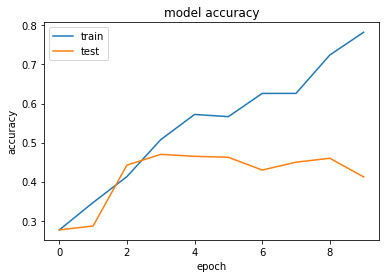

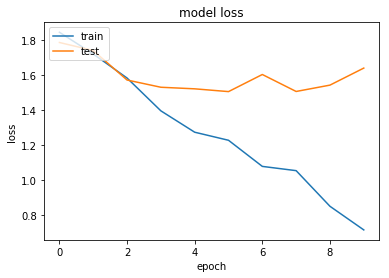

In [26]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Part 3 - Bidirectionnal-LSTM


In [45]:
encoded_tf_train = []
for sentence in train_data:
     encoded_tf_train.append(tf.keras.preprocessing.text.one_hot(sentence,n=50000))

encoded_tf_test = []
for sentence in test_data:
     encoded_tf_test.append(tf.keras.preprocessing.text.one_hot(sentence,n=50000))

In [46]:
paded_tf_test = tf.keras.preprocessing.sequence.pad_sequences(encoded_tf_test,maxlen=8000)
print(paded_tf_test.shape)

paded_tf_train = tf.keras.preprocessing.sequence.pad_sequences(encoded_tf_train,maxlen=8000)
print(paded_tf_train.shape)

(560, 8000)
(1994, 8000)


In [43]:
embed_dim  = 50    # word embedding dimension
nhid       = 32  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 8

model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, embed_dim))
model_LSTM.add(Bidirectional(LSTM(nhid, dropout=0.2)))
model_LSTM.add(Dense(n_classes, activation='softmax'))
#model_LSTM.add(LSTM(nhid, dropout=0.3))
#model_LSTM.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy'
optimizer        =  'adam' 
metrics_classif  =  ['accuracy']


model_LSTM.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

In [47]:
print(model_LSTM.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          2500000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                21248     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
Total params: 2,521,768
Trainable params: 2,521,768
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
VALIDATION_SPLIT = 0.1
num_validation_samples = int(VALIDATION_SPLIT * paded_tf_train.shape[0])

y_train_LSTM = labels[num_validation_samples:]
x_train_LSTM = paded_tf_train[num_validation_samples:]

y_dev_LSTM = labels[:num_validation_samples]
x_dev_LSTM = paded_tf_train[:num_validation_samples]
#x_dev_LSTM = X_train[-num_validation_samples:].toarray()
#x_train_LSTM = X_train[num_validation_samples:].toarray()

bs = 128
n_epochs = 10

history_LSTM = model_LSTM.fit(x_train_LSTM, y_train_LSTM, batch_size=bs, epochs=n_epochs, validation_data=(x_dev_LSTM, y_dev_LSTM))

Train on 1795 samples, validate on 199 samples
Epoch 1/10
1795/1795 [==============================] - 13s 7ms/sample - loss: 2.0221 - accuracy: 0.2797 - val_loss: 1.9109 - val_accuracy: 0.3216
Epoch 2/10
1795/1795 [==============================] - 10s 6ms/sample - loss: 1.8447 - accuracy: 0.2914 - val_loss: 1.7703 - val_accuracy: 0.3216
Epoch 3/10
1795/1795 [==============================] - 11s 6ms/sample - loss: 1.7777 - accuracy: 0.3103 - val_loss: 1.7562 - val_accuracy: 0.2915
Epoch 4/10
1795/1795 [==============================] - 10s 6ms/sample - loss: 1.7394 - accuracy: 0.3504 - val_loss: 1.7410 - val_accuracy: 0.3216
Epoch 5/10
1795/1795 [==============================] - 10s 6ms/sample - loss: 1.6502 - accuracy: 0.3989 - val_loss: 1.7811 - val_accuracy: 0.2412
Epoch 6/10
1795/1795 [==============================] - 10s 6ms/sample - loss: 1.4874 - accuracy: 0.4540 - val_loss: 1.8482 - val_accuracy: 0.2965
Epoch 7/10
1795/1795 [==============================] - 10s 6ms/sample 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


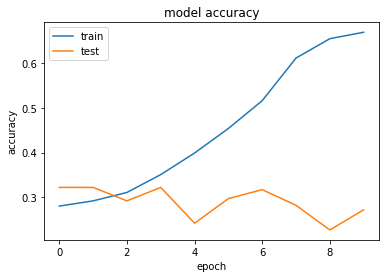

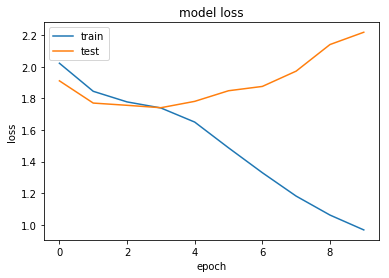

In [49]:
print(history_LSTM.history.keys())
# summarize history for accuracy
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
# summarize history for loss
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()